In [1]:
#Applying blur
import os
import cv2
from PIL import Image
import numpy as np

input_dir = 'dataset/DIV2K_train_HR'
blurred_dir = 'dataset/DIV2K_train_LR'

os.makedirs(blurred_dir, exist_ok=True)

for img_name in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_name)

    try:
        img_pil = Image.open(img_path).convert('RGB')
        img = np.array(img_pil)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        blurred = cv2.GaussianBlur(img, (11, 11), sigmaX=5.0)
        save_path = os.path.join(blurred_dir, img_name)
        cv2.imwrite(save_path, blurred)
    except Exception as e:
        print("Error processing {}: {}".format(img_name, e))

In [2]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class DIV2KSharpenDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.filenames = sorted(os.listdir(input_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        input_img = Image.open(os.path.join(self.input_dir, self.filenames[idx])).convert('RGB')
        target_img = Image.open(os.path.join(self.target_dir, self.filenames[idx])).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = DIV2KSharpenDataset('dataset/DIV2K_train_LR', 'dataset/DIV2K_train_HR', transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [3]:

import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetTeacher(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_features=64):
        super(UNetTeacher, self).__init__()

        self.enc1 = ConvBlock(in_channels, base_features)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_features, base_features * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_features * 2, base_features * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_features * 4, base_features * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base_features * 8, base_features * 16)

        self.upconv4 = nn.ConvTranspose2d(base_features * 16, base_features * 8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(base_features * 16, base_features * 8)

        self.upconv3 = nn.ConvTranspose2d(base_features * 8, base_features * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_features * 8, base_features * 4)

        self.upconv2 = nn.ConvTranspose2d(base_features * 4, base_features * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_features * 4, base_features * 2)

        self.upconv1 = nn.ConvTranspose2d(base_features * 2, base_features, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_features * 2, base_features)

        self.output_conv = nn.Conv2d(base_features, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.output_conv(d1)

In [4]:

import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetTeacher().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for input_img, target_img in tqdm(train_loader):
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        output = model(input_img)
        loss = criterion(output, target_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, running_loss / len(train_loader)))



100%|██████████| 100/100 [09:24<00:00,  5.64s/it]


Epoch [1/20], Loss: 0.1356


100%|██████████| 100/100 [08:53<00:00,  5.33s/it]


Epoch [2/20], Loss: 0.0112


100%|██████████| 100/100 [08:54<00:00,  5.34s/it]


Epoch [3/20], Loss: 0.0066


100%|██████████| 100/100 [08:59<00:00,  5.40s/it]


Epoch [4/20], Loss: 0.0058


100%|██████████| 100/100 [09:06<00:00,  5.46s/it]


Epoch [5/20], Loss: 0.0051


100%|██████████| 100/100 [08:57<00:00,  5.38s/it]


Epoch [6/20], Loss: 0.0042


100%|██████████| 100/100 [09:08<00:00,  5.49s/it]


Epoch [7/20], Loss: 0.0046


100%|██████████| 100/100 [08:55<00:00,  5.35s/it]


Epoch [8/20], Loss: 0.0037


100%|██████████| 100/100 [08:53<00:00,  5.33s/it]


Epoch [9/20], Loss: 0.0040


100%|██████████| 100/100 [09:02<00:00,  5.42s/it]


Epoch [10/20], Loss: 0.0042


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Epoch [11/20], Loss: 0.0043


100%|██████████| 100/100 [08:53<00:00,  5.33s/it]


Epoch [12/20], Loss: 0.0043


100%|██████████| 100/100 [08:54<00:00,  5.34s/it]


Epoch [13/20], Loss: 0.0038


100%|██████████| 100/100 [08:54<00:00,  5.35s/it]


Epoch [14/20], Loss: 0.0038


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Epoch [15/20], Loss: 0.0034


100%|██████████| 100/100 [08:52<00:00,  5.32s/it]


Epoch [16/20], Loss: 0.0030


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Epoch [17/20], Loss: 0.0032


100%|██████████| 100/100 [08:49<00:00,  5.30s/it]


Epoch [18/20], Loss: 0.0032


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Epoch [19/20], Loss: 0.0034


100%|██████████| 100/100 [09:02<00:00,  5.42s/it]

Epoch [20/20], Loss: 0.0030


In [5]:

torch.save(model.state_dict(), 'teacher_unet.pth')


In [6]:
#student model

In [7]:

class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1)  
        )

    def forward(self, x):
        return self.model(x)


In [8]:

teacher = UNetTeacher()
teacher.load_state_dict(torch.load('teacher_unet.pth'))
teacher.eval() 
for param in teacher.parameters():
    param.requires_grad = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher = teacher.to(device)

In [9]:

import torch.nn.functional as F

def distillation_loss(student_output, teacher_output, target, alpha=0.7):
    l1_target = F.l1_loss(student_output, target)
    l1_teacher = F.l1_loss(student_output, teacher_output.detach())
    return alpha * l1_target + (1 - alpha) * l1_teacher


In [10]:

from tqdm import tqdm

student = StudentCNN().to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
num_epochs = 20

for epoch in range(num_epochs):
    student.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc="Epoch [{}/{}]".format(epoch+1, num_epochs))

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            teacher_outputs = teacher(inputs)

        teacher_outputs = teacher_outputs.to(device)  
        student_outputs = student(inputs)

        loss = distillation_loss(student_outputs, teacher_outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (loop.n + 1))

    print("Epoch [{}/{}] Loss: {:.4f}".format(epoch+1, num_epochs, running_loss / len(train_loader)))




Epoch [1/20]: 100%|██████████| 100/100 [04:09<00:00,  2.50s/it, loss=0.197]


Epoch [1/20] Loss: 0.1972


Epoch [2/20]: 100%|██████████| 100/100 [04:06<00:00,  2.47s/it, loss=0.0788]


Epoch [2/20] Loss: 0.0788


Epoch [3/20]: 100%|██████████| 100/100 [04:18<00:00,  2.58s/it, loss=0.0505]


Epoch [3/20] Loss: 0.0505


Epoch [4/20]: 100%|██████████| 100/100 [04:37<00:00,  2.78s/it, loss=0.0406]


Epoch [4/20] Loss: 0.0406


Epoch [5/20]: 100%|██████████| 100/100 [04:48<00:00,  2.89s/it, loss=0.0354]


Epoch [5/20] Loss: 0.0354


Epoch [6/20]: 100%|██████████| 100/100 [04:09<00:00,  2.50s/it, loss=0.0313]


Epoch [6/20] Loss: 0.0313


Epoch [7/20]: 100%|██████████| 100/100 [04:06<00:00,  2.46s/it, loss=0.0277]


Epoch [7/20] Loss: 0.0277


Epoch [8/20]: 100%|██████████| 100/100 [04:03<00:00,  2.43s/it, loss=0.0255]


Epoch [8/20] Loss: 0.0255


Epoch [9/20]: 100%|██████████| 100/100 [04:07<00:00,  2.48s/it, loss=0.0245]


Epoch [9/20] Loss: 0.0245


Epoch [10/20]: 100%|██████████| 100/100 [04:06<00:00,  2.47s/it, loss=0.0239]


Epoch [10/20] Loss: 0.0239


Epoch [11/20]: 100%|██████████| 100/100 [03:58<00:00,  2.39s/it, loss=0.0233]


Epoch [11/20] Loss: 0.0233


Epoch [12/20]: 100%|██████████| 100/100 [03:58<00:00,  2.39s/it, loss=0.0227]


Epoch [12/20] Loss: 0.0227


Epoch [13/20]: 100%|██████████| 100/100 [03:57<00:00,  2.38s/it, loss=0.0222]


Epoch [13/20] Loss: 0.0222


Epoch [14/20]: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it, loss=0.0219]


Epoch [14/20] Loss: 0.0219


Epoch [15/20]: 100%|██████████| 100/100 [03:58<00:00,  2.39s/it, loss=0.0217]


Epoch [15/20] Loss: 0.0217


Epoch [16/20]: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it, loss=0.0214]


Epoch [16/20] Loss: 0.0214


Epoch [17/20]: 100%|██████████| 100/100 [03:59<00:00,  2.39s/it, loss=0.0208]


Epoch [17/20] Loss: 0.0208


Epoch [18/20]: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it, loss=0.0206]


Epoch [18/20] Loss: 0.0206


Epoch [19/20]: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it, loss=0.0203]


Epoch [19/20] Loss: 0.0203


Epoch [20/20]: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it, loss=0.0201]

Epoch [20/20] Loss: 0.0201


In [11]:

from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

student.eval()
total_ssim = 0
num_samples = 0

with torch.no_grad():
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = student(inputs)

        for j in range(outputs.size(0)):
            pred = outputs[j].cpu().permute(1, 2, 0).numpy()
            true = targets[j].cpu().permute(1, 2, 0).numpy()
            pred = np.clip(pred, 0, 1)
            true = np.clip(true, 0, 1)

            ssim_score = ssim(pred, true, channel_axis=-1, win_size=7, data_range=1.0)
            total_ssim += ssim_score
            num_samples += 1

        if i == 2: 
            break

print("Average efficiency SSIM of student model is: %.4f" % ((total_ssim / num_samples)*100),"%")




Average efficiency SSIM of student model is: 94.5394 %


In [12]:
#WORKING

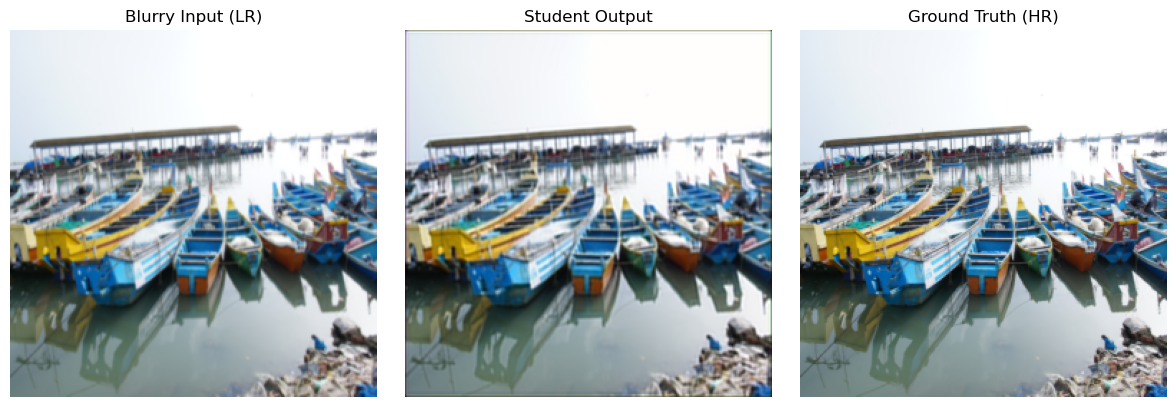

In [13]:

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
student.eval()

with torch.no_grad():
    outputs = student(inputs)


input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
output_img = outputs[0].cpu().permute(1, 2, 0).numpy()
target_img = targets[0].cpu().permute(1, 2, 0).numpy()


input_img = np.clip(input_img, 0, 1)
output_img = np.clip(output_img, 0, 1)
target_img = np.clip(target_img, 0, 1)

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Blurry Input (LR)")
plt.imshow(input_img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Student Output")
plt.imshow(output_img)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Ground Truth (HR)")
plt.imshow(target_img)
plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
# SAVING AND SHOWCASING STUDENT MODEL'S OUTPUT

In [15]:

import numpy as np
from torchvision.utils import save_image


os.makedirs("results", exist_ok=True)


inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)

student.eval()
with torch.no_grad():
    outputs = student(inputs)


for i in range(3):
    input_img = inputs[i].cpu().permute(1, 2, 0).numpy()
    output_img = outputs[i].cpu().permute(1, 2, 0).numpy()
    target_img = targets[i].cpu().permute(1, 2, 0).numpy()

   
    input_img = np.clip(input_img, 0, 1)
    output_img = np.clip(output_img, 0, 1)
    target_img = np.clip(target_img, 0, 1)

    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(input_img)
    axes[0].set_title("Blurry Input")
    axes[0].axis("off")

    axes[1].imshow(output_img)
    axes[1].set_title("Student Output")
    axes[1].axis("off")

    axes[2].imshow(target_img)
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig("results/sample_{}.png".format(i + 1))
    plt.close()

print("Saved outputs in 'results/' folder.")


Saved outputs in 'results/' folder.


In [16]:
import time
start = time.time()

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        _ = student(inputs)

end = time.time()
total_time = end - start
fps = len(train_loader.dataset) / total_time

print("Estimated FPS on full dataset: %.2f" % fps)

Estimated FPS on full dataset: 9.65


In [18]:
from torchvision.utils import save_image
from pathlib import Path

mos_path = Path("results_mos")
mos_path.mkdir(exist_ok=True)

student.eval()
teacher.eval()

with torch.no_grad():
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= 5:
            break
        inputs = inputs.to(device)
        targets = targets.to(device)
        teacher_out = teacher(inputs)
        student_out = student(inputs)

        for j in range(inputs.size(0)):
            sample_dir = mos_path / f"sample_{i*inputs.size(0)+j+1}"
            sample_dir.mkdir(parents=True, exist_ok=True)

            save_image(inputs[j], sample_dir / "input.png")
            save_image(teacher_out[j], sample_dir / "teacher.png")
            save_image(student_out[j], sample_dir / "student.png")
            save_image(targets[j], sample_dir / "ground_truth.png")

print("Generated samples for MOS evaluation in 'results_mos/' folder.")


Generated samples for MOS evaluation in 'results_mos/' folder.
